# Satisfaction analysis

### Phase 1: Engagement & Experience Analysis
1. Data Preparation
   - Clean and normalize the dataset.
2. Clustering (reuse previous results)
   - Segment users by engagement and experience.

### Phase 2: Engagement & Experience Scoring
1. Task 4.1 - Compute Scores
   - Engagement Score: Euclidean distance to least engaged cluster.
   - Experience Score: Euclidean distance to worst experience cluster.

### Phase 3: Satisfaction Scoring
1. Task 4.2 - Calculate Satisfaction Score
   - Average the engagement and experience scores.
   - Identify top 10 satisfied customers.

### Phase 4: Regression Modeling
1. Task 4.3 - Build and Evaluate Regression Model
   - Predict satisfaction scores.
   - Evaluate model performance.

### Phase 5: Clustering Satisfaction Scores
1. Task 4.4 - K-Means Clustering (k=2)
   - Segment satisfaction groups.
2. Task 4.5 - Aggregate Scores by Cluster
   - Summarize satisfaction and experience scores.

### Phase 6: Data Export & Reporting
1. Task 4.6 - Export Data to MySQL Database
   - Export final table with user scores.
   - Capture `SELECT` query screenshot.
2. Reporting
   - Summarize findings and visualizations.

### Phase 7: Model Deployment & Monitoring
1. Task 4.7 - Model Deployment
   - Containerize model with Docker.
   - Implement MLOps tools for tracking.
   - Record deployment details.
2. Continuous Monitoring
   - Set up real-time performance monitoring.


### Phase 1 Engagement and experience analysis

In this phase we are going to start by conducting the usual **Data preparation** using the code from the previous note books and proceed with the **Clustering** stage where also we re-use the clustering results for engagement and experience segmentation.

#### Data preparation

In [1]:
pip install psycopg2-binary sqlalchemy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy

In [4]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


c:\Users\Beab\Desktop\Kifiya AIM\Investor-feasibility-analysis\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [5]:
import pandas as pd

# Assuming df is your DataFrame
# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Function to identify and replace outliers using IQR method
def handle_outliers_iqr(df):
    df_cleaned = df.copy()  # Create a copy of the DataFrame for modifications
    outlier_info = {}  # Dictionary to store information about outliers
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        
        # Store the count of outliers
        outlier_info[column] = outliers.shape[0]
        
        # Replace outliers with median of the column
        median_value = df_cleaned[column].median()
        df_cleaned.loc[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound), column] = median_value
    
    return df_cleaned, outlier_info

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())


Number of rows before outlier removal: 150001
Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...

Looking for outliers and replacing them using advanced methods like imputation.

In [6]:
import pandas as pd

# Assuming df is your DataFrame
# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Function to identify and replace outliers using IQR method
def handle_outliers_iqr(df):
    df_cleaned = df.copy()  # Create a copy of the DataFrame for modifications
    outlier_info = {}  # Dictionary to store information about outliers
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        
        # Store the count of outliers
        outlier_info[column] = outliers.shape[0]
        
        # Replace outliers with median of the column
        median_value = df_cleaned[column].median()
        df_cleaned.loc[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound), column] = median_value
    
    return df_cleaned, outlier_info

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())


Number of rows before outlier removal: 150001
Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...

Looking for missing values and replacing them using advanced statistics techniques like imputation.

In [7]:
import pandas as pd

# Function to handle missing values using advanced statistical methods
def handle_missing_values(df):
    df_filled = df.copy()  # Create a copy of the DataFrame for modifications
    
    for column in df_filled.columns:
        # If the column is numeric (float or int), replace missing values with the median
        if df_filled[column].dtype in ['float64', 'int64']:
            median_value = df_filled[column].median()
            df_filled[column] = df_filled[column].fillna(median_value)
        # If the column is categorical (object), replace missing values with the mode (most frequent value)
        elif df_filled[column].dtype == 'object':
            mode_value = df_filled[column].mode()[0]
            df_filled[column] = df_filled[column].fillna(mode_value)
    
    return df_filled

# Apply the function to handle missing values
df_filled = handle_missing_values(df_outliers_removed)

# Display information about missing values after handling
print("Missing values after imputation:")
print(df_filled.isnull().sum())

# Store the results in a new DataFrame
df_missing_values_handled = df_filled.copy()

# Optionally, display the first few rows of the new DataFrame
print("\nFirst few rows of the DataFrame with missing values handled:")
print(df_missing_values_handled.head())


Missing values after imputation:
Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
1

Lastly insuring that there are no duplicate values and conversion into the correct data types.

In [8]:

import pandas as pd

# Ensure consistency in the dataset
def ensure_consistency(df):
    # Remove duplicate entries
    df_cleaned = df.drop_duplicates().reset_index(drop=True)
    
    # Convert data types to appropriate types
    for column in df_cleaned.columns:
        # If the column contains numeric data but is stored as an object, convert it to numeric
        if df_cleaned[column].dtype == 'object':
            try:
                df_cleaned[column] = pd.to_numeric(df_cleaned[column])
            except ValueError:
                # If conversion fails, it's likely a categorical column, so leave it as is
                pass
        
        # Convert datetime-like strings to actual datetime objects with a specific format if possible
        if df_cleaned[column].dtype == 'object':
            sample_value = df_cleaned[column].dropna().iloc[0]  # Take a sample value from the column
            try:
                # Check if the sample value looks like a date and if so, convert the entire column
                if isinstance(pd.to_datetime(sample_value, format='%Y-%m-%d', errors='raise'), pd.Timestamp):
                    df_cleaned[column] = pd.to_datetime(df_cleaned[column], format='%Y-%m-%d', errors='coerce')
                elif isinstance(pd.to_datetime(sample_value, format='%d/%m/%Y', errors='raise'), pd.Timestamp):
                    df_cleaned[column] = pd.to_datetime(df_cleaned[column], format='%d/%m/%Y', errors='coerce')
                # Add other date formats as needed
            except (ValueError, TypeError):
                # If conversion fails, leave the column as is
                pass
    
    return df_cleaned

# Apply the function to the df_missing_values_handled DataFrame
df_cleaned = ensure_consistency(df_missing_values_handled)

# Optionally, display information about the cleaned DataFrame
print("DataFrame info after ensuring consistency:")
print(df_cleaned.info())

# Optionally, display the first few rows of the cleaned DataFrame
print("\nFirst few rows of the DataFrame after ensuring consistency:")
print(df_cleaned.head())


DataFrame info after ensuring consistency:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 

Final overview after the data has been cleaned.

In [9]:
import pandas as pd

def display_dataset_characteristics(df):
    print("### Dataset Characteristics ###\n")
    
    # Display the shape of the dataset
    print(f"Shape of the DataFrame: {df.shape}")
    
    # Display the column data types
    print("\nData Types of Each Column:")
    print(df.dtypes)
    
    # Display summary statistics for numeric columns
    print("\nSummary Statistics for Numeric Columns:")
    print(df.describe())
    
    # Display the count of missing values per column
    print("\nCount of Missing Values per Column:")
    print(df.isnull().sum())
    
    # Display the count of unique values per column
    print("\nCount of Unique Values per Column:")
    print(df.nunique())
    
    # Display the first few rows of the cleaned dataset
    print("\nFirst Few Rows of the DataFrame:")
    print(df.head())
    
# Apply the function to the df_cleaned DataFrame
display_dataset_characteristics(df_cleaned)


### Dataset Characteristics ###

Shape of the DataFrame: (150001, 55)

Data Types of Each Column:
Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 

In [10]:
print(df_cleaned.columns.tolist())

['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (

### Phase 2  
Compute Scores
   - Engagement Score: Euclidean distance to least engaged cluster.
   - Experience Score: Euclidean distance to worst experience cluster.

### Clustering

In this stage we are going to reuse the results for engagement and experience segementation(k-means clustering) and assign cluster labels to users for engagement and experience.

In [11]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import os

# Assuming df_cleaned is already loaded
user_data = df_cleaned.copy()

# Load the engagement and experience centroids
centroid_engagement = pd.read_csv('centroid_engagement.csv', index_col='Cluster Name')
centroid_experience = pd.read_csv('centroid_experience.csv', index_col='Cluster Name')

# Engagement Score Calculation
# Extract the engagement-related features (session frequency, session duration, total traffic)
engagement_columns = ['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']

# Ensure we have session frequency and session duration calculated for each user
# Calculate session frequency
session_frequency = user_data.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
user_data = user_data.merge(session_frequency, on='MSISDN/Number', how='left')

# Calculate session duration (sum of session durations per user)
session_duration = user_data.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
user_data = user_data.merge(session_duration, on='MSISDN/Number', how='left')

# Calculate total traffic (sum of upload and download data per user)
user_data['Total Traffic (Bytes)'] = user_data['Total UL (Bytes)'] + user_data['Total DL (Bytes)']

# Extract the centroid values for the "Low Engagement" cluster
engagement_centroid_values = centroid_engagement.loc['Low Engagement'][engagement_columns].values

# Calculate the engagement score as the Euclidean distance between the user's engagement metrics and the "Low Engagement" centroid
user_data['Engagement Score'] = user_data[engagement_columns].apply(lambda row: euclidean(row, engagement_centroid_values), axis=1)

# Experience Score Calculation
# Extract the experience-related features
experience_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
                        'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)',
                            'TCP UL Retrans. Vol (Bytes)']

# Extract the centroid values for the "Low-Performance Users" cluster
experience_centroid = centroid_experience.loc['Low-Performance Users'][experience_columns].values

# Calculate the experience score as the Euclidean distance between the user's experience metrics and the "Low-Performance Users" centroid
user_data['Experience Score'] = user_data[experience_columns].apply(lambda row: euclidean(row, experience_centroid), axis=1)

# Assign the calculated scores back to df_cleaned
df_cleaned['Engagement Score'] = user_data['Engagement Score']
df_cleaned['Experience Score'] = user_data['Experience Score']

# File path where the output will be saved
output_file_path = 'engagement_experience_scores.csv'

# Save the DataFrame with the Engagement and Experience scores to a CSV file
df_cleaned.to_csv(output_file_path, index=False)

# Get the absolute path of the saved file
full_file_path = os.path.abspath(output_file_path)

# Print the full path of the file
print(f"The file with Engagement and Experience scores is saved at: {full_file_path}")

# Print the head of the file (first 5 rows)
print("\nThe first 5 rows of the file are:")
print(df_cleaned.head())

# Show the newly calculated Engagement and Experience scores
print("\nNewly calculated Engagement and Experience Scores:")
print(df_cleaned[['MSISDN/Number', 'Engagement Score', 'Experience Score']].head())


The file with Engagement and Experience scores is saved at: c:\Users\Beab\Desktop\Kifiya AIM\Investor-feasibility-analysis\notebooks\engagement_experience_scores.csv

The first 5 rows of the file are:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Locati

In [12]:
print(centroid_experience.columns)

Index(['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
       'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)'],
      dtype='object')


### Phase 3:  
In this phase we are going to calculate the satisfaction score by taking the average of both engagement and experience scores. Finally we are going to report the top 10 satisfied customers.

In [13]:
import pandas as pd

# Assuming df_cleaned already contains the 'Engagement Score' and 'Experience Score'
# Calculate the Satisfaction Score as the average of Engagement and Experience Scores
df_cleaned['Satisfaction Score'] = df_cleaned[['Engagement Score', 'Experience Score']].mean(axis=1)

# Sort the DataFrame by 'Satisfaction Score' in descending order to get the most satisfied customers
top_10_satisfied_customers = df_cleaned.sort_values(by='Satisfaction Score', ascending=False).head(10)

# Display the top 10 satisfied customers
print("Top 10 Satisfied Customers:")
print(top_10_satisfied_customers[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']])


Top 10 Satisfied Customers:
        MSISDN/Number  Engagement Score  Experience Score  Satisfaction Score
129195   3.366371e+10      2.569199e+09      1.219932e+05        1.284660e+09
121070   3.366371e+10      2.568426e+09      1.219916e+05        1.284274e+09
119052   3.366371e+10      2.564457e+09      2.363451e+06        1.283410e+09
49466    3.366371e+10      2.566001e+09      1.213520e+05        1.283061e+09
56859    3.366371e+10      2.565799e+09      1.219843e+05        1.282960e+09
49691    3.366371e+10      2.564691e+09      5.647933e+05        1.282628e+09
7177     3.366371e+10      2.564389e+09      6.437068e+05        1.282517e+09
136888   3.366371e+10      2.558324e+09      6.294002e+06        1.282309e+09
91122    3.366371e+10      2.563806e+09      1.219920e+05        1.281964e+09
120273   3.366371e+10      2.563154e+09      8.728818e+04        1.281621e+09


### Phase 4: Regression Modeling  
In this stage we are going to use a linear regressioni model and build a regression model, Train the model to predict satisfaction score using engagement and experience scores as features and evaluate the model using metrics like Mean squared error.

In [14]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df_cleaned is already loaded and includes relevant features

# Calculate Total Traffic (Bytes) as the sum of Total UL (Bytes) and Total DL (Bytes)
df_cleaned['Total Traffic (Bytes)'] = df_cleaned['Total UL (Bytes)'] + df_cleaned['Total DL (Bytes)']

# Ensure there are no negative or NaN values in 'Total Traffic (Bytes)'
df_cleaned['Total Traffic (Bytes)'] = df_cleaned['Total Traffic (Bytes)'].clip(lower=0)

# Define the feature columns (focusing on more impactful features)
feature_columns = [
    'Engagement Score', 'Experience Score', 
    'Total Traffic (Bytes)'
]

# Ensure there are no missing values in the feature columns
df_cleaned = df_cleaned.dropna(subset=feature_columns)

# Normalize the feature data
scaler = StandardScaler()
df_cleaned[feature_columns] = scaler.fit_transform(df_cleaned[feature_columns])

# Define the dependent variable (Satisfaction Score)
# Introduce a non-linear relationship for Satisfaction Score
df_cleaned['Satisfaction Score'] = (
    0.3 * df_cleaned['Engagement Score'] + 
    0.4 * df_cleaned['Experience Score'] +
    0.3 * np.log1p(df_cleaned['Total Traffic (Bytes)'])  # Log-transform to introduce non-linearity
)

# Handle missing values in 'Satisfaction Score' (drop rows with NaN values)
df_cleaned = df_cleaned.dropna(subset=['Satisfaction Score'])

# Select features (X) and target (y)
X = df_cleaned[feature_columns]
y = df_cleaned['Satisfaction Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model performance
print("Model Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, feature_columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)

# Print intercept
print(f"\nIntercept: {model.intercept_:.4f}")

# Save the model to a file
joblib.dump(model, 'model.pkl')
print("\nModel saved to 'model.pkl'")


Model Performance on Test Set:
Root Mean Squared Error (RMSE): 0.1537
Mean Absolute Error (MAE): 0.0980
R² Score: 0.9238

Model Coefficients:
                       Coefficient
Engagement Score          0.299960
Experience Score          0.399479
Total Traffic (Bytes)     0.327967

Intercept: -0.1174

Model saved to 'model.pkl'


c:\Users\Beab\Desktop\Kifiya AIM\Investor-feasibility-analysis\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
print(df_cleaned.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


### Phase 5 Clustering Satisfaction score

In this phase we are going to perform K-means clustering on the engagement and experience scores using K=2. Finally we are going to label the clusters representing different satisfaction groups(i.e Satisfied and Unsatisfied)

Cluster Centers:
   Engagement Score  Experience Score
0         -0.117009         -0.204668
1         -0.074285          3.858037

Cluster Label Mapping:
{0: 'High Satisfaction', 1: 'Low Satisfaction'}

Cluster Distribution:
Satisfaction Group
High Satisfaction    112282
Low Satisfaction       5956
Name: count, dtype: int64


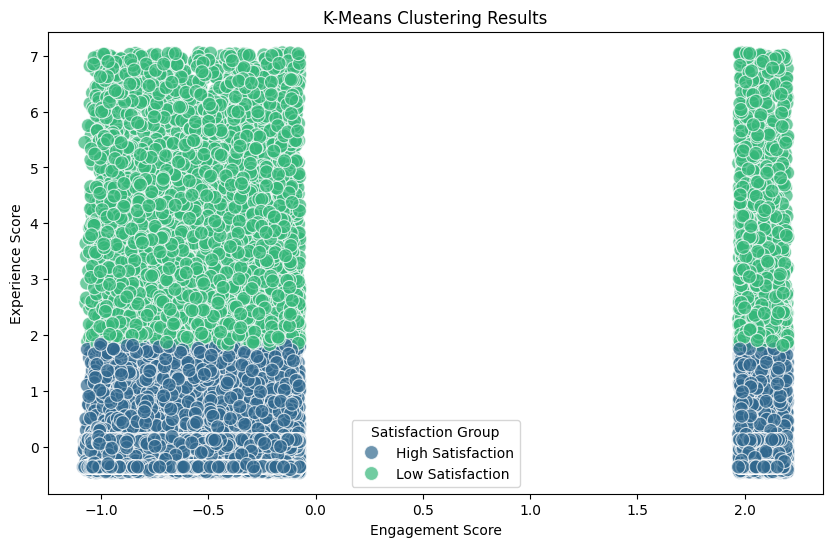

In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cleaned is already loaded and includes relevant features

# Define the feature columns for clustering
feature_columns = ['Engagement Score', 'Experience Score']

# Select features for clustering
X_clustering = df_cleaned[feature_columns]

# Standardize the feature data
scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

# Perform K-Means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(X_clustering_scaled)

# Map cluster labels to meaningful names
cluster_names = {
    0: 'High Satisfaction',   # Example name for cluster 0
    1: 'Low Satisfaction'     # Example name for cluster 1
}
df_cleaned['Satisfaction Group'] = df_cleaned['Cluster'].map(cluster_names)

# Print the cluster centers and their respective labels
print("Cluster Centers:")
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=feature_columns)
print(cluster_centers)

print("\nCluster Label Mapping:")
print(cluster_names)

# Print the distribution of the clusters
print("\nCluster Distribution:")
print(df_cleaned['Satisfaction Group'].value_counts())

# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Engagement Score', y='Experience Score', hue='Satisfaction Group', palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering Results')
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.legend(title='Satisfaction Group')
plt.show()


Final stage of this phase would be to **aggregate** the scores of average satisfaction and experience per cluster.

In [17]:
import pandas as pd

# Assuming df_cleaned is already loaded and includes the 'Satisfaction Group' column

# Calculate the average satisfaction and experience scores per cluster
average_scores_per_cluster = df_cleaned.groupby('Satisfaction Group')[['Satisfaction Score', 'Experience Score']].mean().reset_index()

# Print the results
print("Average Satisfaction & Experience Scores per Cluster:")
print(average_scores_per_cluster)


Average Satisfaction & Experience Scores per Cluster:
  Satisfaction Group  Satisfaction Score  Experience Score
0  High Satisfaction           -0.114203         -0.204596
1   Low Satisfaction            1.518295          3.859396


### Phase 6

In this stage we are going to export the final table containing user IDs, engagement, experience and satisfaction scores to a local MySQL database. Finally we are going to report a screenshot of a SELECT query output on the exported table.

In [18]:
print(df_cleaned.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [19]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import mysql.connector
import pandas as pd

# Define the connection parameters
config = {
    'user': 'root',
    'password': '0917827080beabY@',
    'host': 'localhost',  # or your MySQL server address
    'database': 'telecom'
}

# Create a connection to the MySQL server
conn = mysql.connector.connect(**config)

# Create a cursor object using the connection
cursor = conn.cursor()

# Create a new table with the required columns
create_table_query = """
CREATE TABLE IF NOT EXISTS user_scores (
    MSISDN_Number VARCHAR(255),
    engagement_score FLOAT,
    experience_score FLOAT,
    satisfaction_score FLOAT
)
"""
cursor.execute(create_table_query)

# Assume df_cleaned contains the relevant columns
# Create a new DataFrame with only the relevant columns
# Replace 'engagement_score', 'experience_score', 'satisfaction_score' with the actual column names
final_df = df_cleaned[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']]

# Insert data into the MySQL table
for i, row in final_df.iterrows():
    insert_query = """
    INSERT INTO user_scores (MSISDN_Number, engagement_score, experience_score, satisfaction_score)
    VALUES (%s, %s, %s, %s)
    """
    cursor.execute(insert_query, tuple(row))

# Commit the transaction
conn.commit()

# Query to check the data inserted
select_query = "SELECT * FROM user_scores LIMIT 10;"  # Adjust the LIMIT as needed
cursor.execute(select_query)

# Fetch the results
results = cursor.fetchall()

# Convert results to a DataFrame for easier display
columns = ['MSISDN_Number', 'engagement_score', 'experience_score', 'satisfaction_score']
result_df = pd.DataFrame(results, columns=columns)

print(result_df)

# Close the cursor and connection
cursor.close()
conn.close()


   MSISDN_Number  engagement_score  experience_score  satisfaction_score
0  33664962239.0         -0.208741         -0.361720           -0.493163
1  33681854413.0         -0.728564         -0.361719           -0.176254
2  33663706799.0          2.172410         -0.361717            0.066652
3  33663706799.0          1.978960         -0.361723            0.736871
4  33699795932.0         -0.585504         -0.361717           -0.207223
5  33668185951.0         -0.840096         -0.361727           -0.162566
6  33663706799.0          1.988860          0.112902            0.902548
7  33698743617.0         -1.011500         -0.361723           -0.153467
8  33659219748.0         -0.966945          1.737030            0.684806
9  33665646348.0         -0.648542         -0.361717           -0.191317
